# Prediccion del indice S&P 500 mediante XGBOOST y el modelo GARCH

In [1]:
# base
import pandas as pd
import numpy as np
import math
import datetime
import datetime as dt
import statsmodels.api as sms


# importacion datos financieros
import yfinance as yf

#metricas de evaluacion 

from arch.unitroot import PhillipsPerron , KPSS , ADF
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error,mean_absolute_error

# Graficas
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from plotly.subplots import make_subplots
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns


# Prediccion modelos GARCH
from pmdarima import auto_arima
import arch
from arch import arch_model

# Prediccion modelo XGBOOST
import xgboost as xgb


# Lectura de datos

In [2]:
data = yf.download(tickers = '^GSPC',start='2021-01-01',end='2023-10-05',interval='1d')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,3764.610107,3769.989990,3662.709961,3700.649902,3700.649902,5015000000
2021-01-05,3698.020020,3737.830078,3695.070068,3726.860107,3726.860107,4591020000
2021-01-06,3712.199951,3783.040039,3705.340088,3748.139893,3748.139893,6064110000
2021-01-07,3764.709961,3811.550049,3764.709961,3803.790039,3803.790039,5099160000
2021-01-08,3815.050049,3826.689941,3783.600098,3824.679932,3824.679932,4773040000


In [3]:
data = data.rename(columns=str.lower)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 596 entries, 2021-01-04 to 2023-05-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       596 non-null    float64
 1   high       596 non-null    float64
 2   low        596 non-null    float64
 3   close      596 non-null    float64
 4   adj close  596 non-null    float64
 5   volume     596 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 32.6 KB


In [4]:
data['time'] = data.index

In [5]:
retornos = data[['close']].pct_change().dropna() * 100
retornos.head()

,close
Date,
2021-01-05,0.708260
2021-01-06,0.570984
2021-01-07,1.484740
2021-01-08,0.549186
2021-01-11,-0.655475


In [6]:
# media rendimientos diarios
retornos.mean()

close    0.02468
dtype: float64

In [7]:
# grafica de los retornos
close_price = retornos
rendimiento_acum_dia = close_price/close_price.iloc[0,:]
fig = px.line(rendimiento_acum_dia.iloc[:,:])
fig.update_layout(title_text='Redimiento acumulado diario S&P 500')
fig.show()

In [8]:
# volatilidad diaria
daily_volatility = retornos.values.std()
daily_volatility

1.186837652623459

In [9]:
monthly_volatility = math.sqrt(21)*daily_volatility # 21 porque hay 21 dias habiles en el mes
monthly_volatility

5.438773380770705

<AxesSubplot:title={'center':'Rtornos diarios'}, xlabel='Date'>

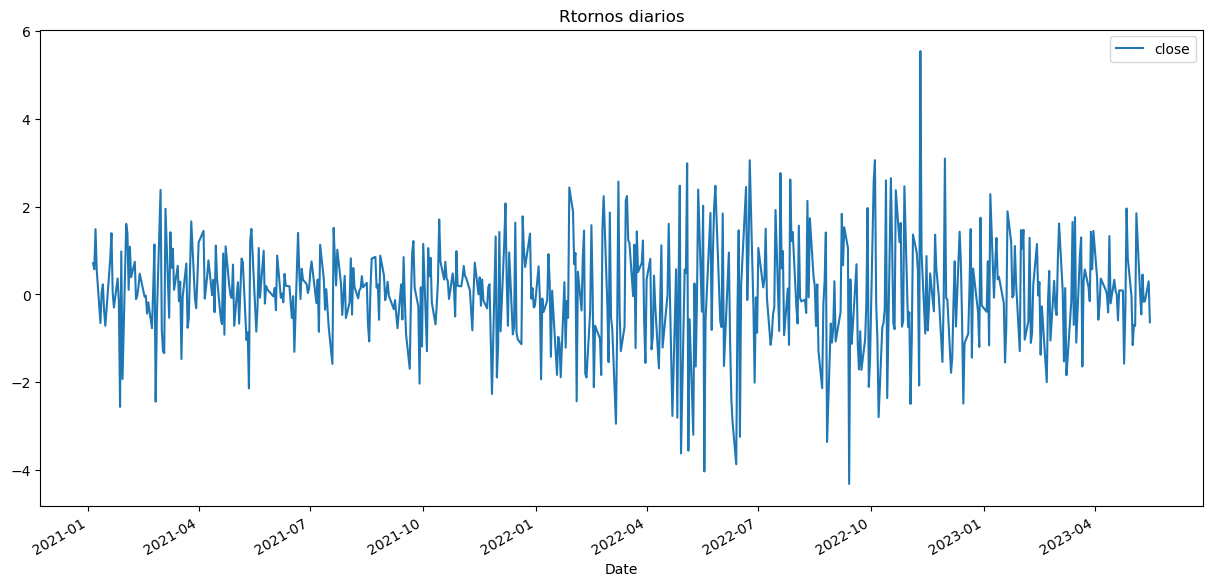

In [10]:
# retornos diarios sin acumulado
retornos.plot(figsize=(15,7),title='Rtornos diarios')

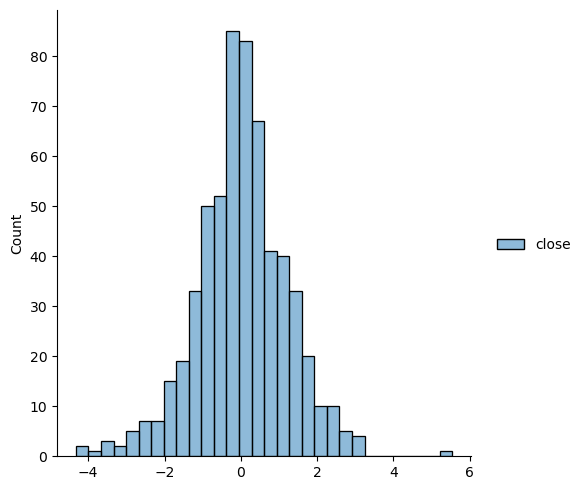

In [11]:
sns.displot(retornos)

# Modelo GARCH 

## Test de estacionariedad
* ADF :

$H_0$ = El proceso contiene raiz unitaria

$H_1$ = El proceso es debilmente estacionario

* PP:

$H_0$ = El proceso contiene raiz unitaria

$H_1$ = El proceso es debilmente estacionario

* KPSS :

$H_0$ = El proceso es debilmente estacionario

$H_1$ = El proceso contiene raiz unitaria

In [12]:
def Estacionariedad(data):
  """
  Realiza el test ADF, PP, KPSS sobre una serie de tiempo indicada en df 
  y una columna en especifico indicada en pais
  """
  adf_pvalue = round(ADF(data).pvalue, 6)
  pp_pvalue = round(PhillipsPerron(data).pvalue, 6)
  kpss_pvalue = round(KPSS(data).pvalue, 6)
  
  results = {'ADF': [adf_pvalue], 'PP': [pp_pvalue], 'KPSS': [kpss_pvalue]}
  df_tests = pd.DataFrame(results)
  
  return df_tests


In [13]:
Estacionariedad(retornos)

,ADF,PP,KPSS
0,0.0,0.0,0.419927


como p-valor < $\alpha$ se rechaza $H_o$ para el test ADF Y PP
y se acepta KPSS. No parece haber reiz unitaria en los retornos del activo

## Grafica ACF y PACF

c:\Users\Juan Guzman\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



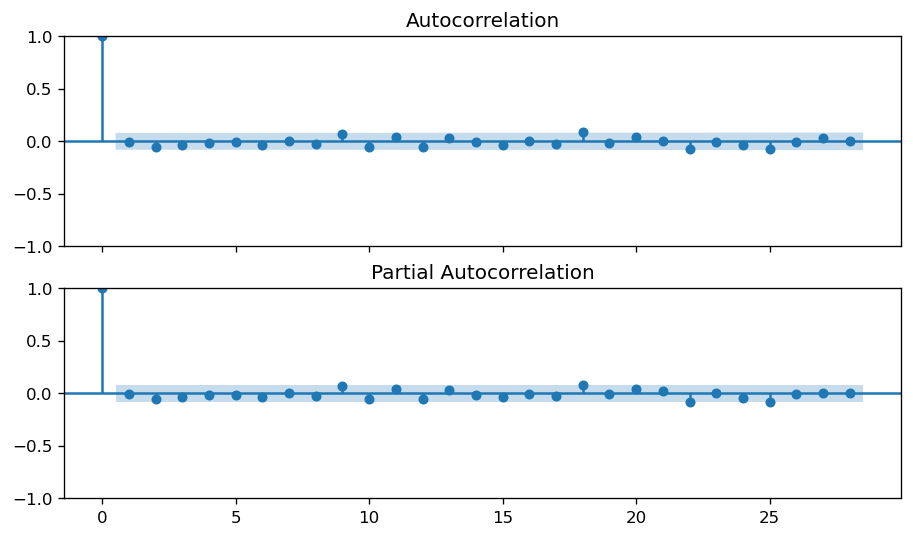

In [14]:
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})

fig, axes = plt.subplots(2, 1, sharex=True)

plot_acf(retornos,ax=axes[0])
plot_pacf(retornos,ax=axes[1])
plt.show()

convergen rapidamente al intervalo

## estimacion modelo

In [15]:
import arch
from arch import arch_model

# Crear un modelo GARCH
model = arch_model(retornos,dist='ged', vol='Garch',p=4,q=4)
model_fit = model.fit(disp='off')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -896.570
Distribution:                  Normal   AIC:                           1813.14
Method:            Maximum Likelihood   BIC:                           1857.02
                                        No. Observations:                  595
Date:                Tue, May 16 2023   Df Residuals:                      594
Time:                        15:37:49   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0570  3.954e-02      1.442      0.149 [-2.049e-02,  0.134]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0359  3.807e-02      0.943      0.346   [-3.871e-02,  0.111]
alpha[1]       0.0402  5.910e-02      0.680      0.497   [-7.567e-02,  0.156]
alpha[2]       0.1026  5.040e-02      2.036  4.172e-02    [3.845e-03,  0.201]
alpha[3]       0.0467  7.823e-02      0.597      0.551      [ -0.107,  0.200]
alpha[4]       0.0000  4.059e-02      0.000      1.000 [-7.956e-02,7.956e-02]
beta[1]        0.0000      0.801      0.000      1.000      [ -1.570,  1.570]
beta[2]    5.1117e-15      0.744  6.874e-15      1.000      [ -1.457,  1.457]
beta[3]        0.3480      0.611      0.570      0.569      [ -0.850,  1.546]
beta[4]        0.4377      0.566      0.774      0.439      [ -0.671,  1.546]
=============================================================================

Covariance estimator: robust
"""

realizar una media movil de 15 dias de los rendimientos

In [16]:
# definir la serie completa como el modelo previamente definido
full_serie_garch = arch_model(retornos,dist='ged',vol='GARCH',p=4,q=4)
# ajuste del modelo para la serie completa
model_fit_full_serie = full_serie_garch.fit(disp='off')

In [18]:
# conspiraremos contra la volatilidad rodante
# promedio movil de 15 dias de los rendimientos
rolling_vol = abs(retornos.rolling(window=15,min_periods=15).std().dropna())
rolling_vol

,close
Date,
2021-01-26,0.668991
2021-01-27,0.977675
2021-01-28,0.998550
2021-01-29,1.042418
2021-02-01,1.125609
...,...
2023-05-10,0.989217
2023-05-11,0.977655
2023-05-12,0.978227


In [20]:
# Concatenar los valores verdaderos y los entrenados por el modelo
garch_and_rolling_std = pd.concat([pd.DataFrame(model_fit_full_serie.conditional_volatility),rolling_vol.dropna()],axis=1).dropna()
garch_and_rolling_std

,cond_vol,close
Date,,
2021-01-26,0.786244,0.668991
2021-01-27,0.813781,0.977675
2021-01-28,0.932706,0.998550
2021-01-29,1.197727,1.042418
2021-02-01,1.087609,1.125609
...,...,...
2023-05-10,0.968450,0.989217
2023-05-11,0.877205,0.977655
2023-05-12,0.912638,0.978227


In [21]:
garch_and_rolling_std_plot = px.line(garch_and_rolling_std,
                                     title="GARCH vs rolling volatilidad de los retonros diarios")
garch_and_rolling_std_plot.show()

Usando un rango de 180 dias para pronosticar los valores, para cada dia estamos ajustando un nuveo modelo con los mismos parametros, pero agregando el ultimo dia


In [22]:
test_size = 180
rolling_predictions = [] #180 predicciones

for i in range(test_size):
    train = retornos[:-(test_size-i)]
    model = arch_model(train,dist="ged",vol='GARCH',p=4,q=4)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1,reindex=False)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [24]:
rolling_predictions[:10] # primeros 10

[1.6122345110876068,
 1.839215138737907,
 1.5950895072694056,
 1.2434019061610162,
 1.4149612322522431,
 1.383998993643723,
 1.1895477208276488,
 1.241174617909493,
 1.338974226915523,
 1.2865920149197794]

In [26]:
# guardar las pred en un DF
rolling_pred = pd.DataFrame(rolling_predictions,index=retornos.index[-test_size:])
rolling_pred = rolling_pred.rename(columns={0:'pred'})
rolling_pred

,pred
Date,
2022-08-29,1.612235
2022-08-30,1.839215
2022-08-31,1.595090
2022-09-01,1.243402
2022-09-02,1.414961
...,...
2023-05-10,0.976318
2023-05-11,0.880315
2023-05-12,0.915036


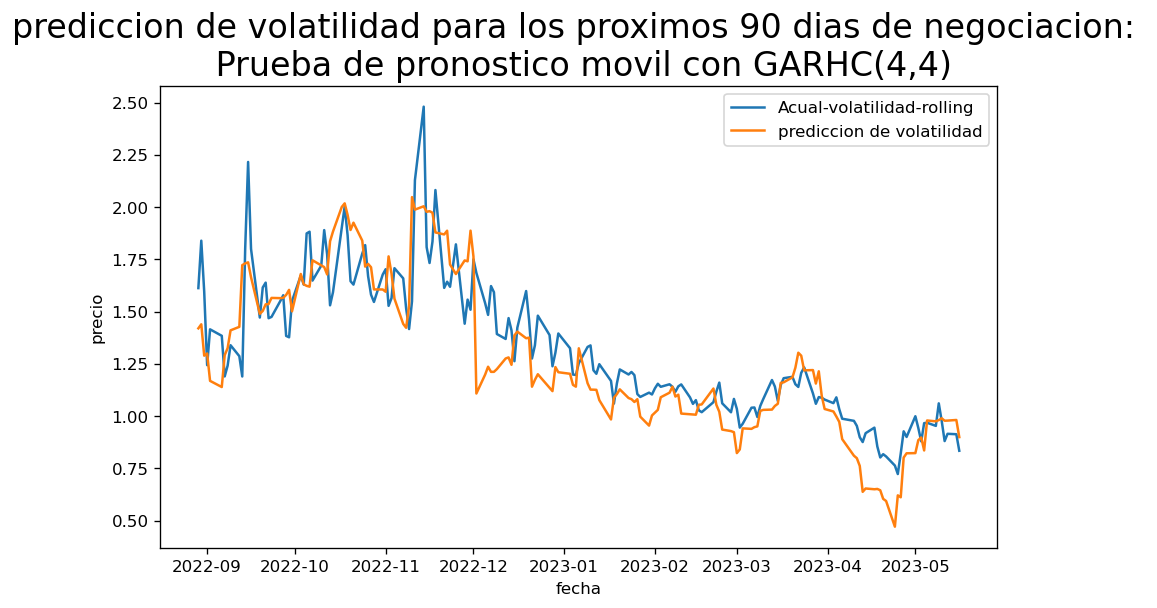

In [28]:
# graficar los datos reales y las predicciones de volatilidad
plt.plot(rolling_pred,label='Acual-volatilidad-rolling')
plt.plot((rolling_vol)[-test_size:],label='prediccion de volatilidad')
plt.title('prediccion de volatilidad para los proximos 90 dias de negociacion: \n Prueba de pronostico movil con GARHC(4,4)',fontsize=20)
plt.xlabel('fecha')
plt.ylabel('precio')
plt.legend()
plt.show()


# GXBOOST

In [29]:
df = yf.download(tickers = '^GSPC',start='2021-01-01',end='2023-10-05',interval='1d')
df_ml = df[['Close']]
df_ml.head()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2021-01-04,3700.649902
2021-01-05,3726.860107
2021-01-06,3748.139893
2021-01-07,3803.790039
2021-01-08,3824.679932


In [30]:
# retornos
df_ml['retornos'] = 100 * df_ml['Close'].pct_change()
df_ml = df_ml.dropna()
df_ml.head()

C:\Users\Juan Guzman\AppData\Local\Temp\ipykernel_17776\2464780598.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Close,retornos
Date,,
2021-01-05,3726.860107,0.708260
2021-01-06,3748.139893,0.570984
2021-01-07,3803.790039,1.484740
2021-01-08,3824.679932,0.549186
2021-01-11,3799.610107,-0.655475


In [33]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 595 entries, 2021-01-05 to 2023-05-16
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     595 non-null    float64
 1   retornos  595 non-null    float64
dtypes: float64(2)
memory usage: 13.9 KB


In [34]:
df_ml.describe()

,Close,retornos
count,595.000000,595.000000
mean,4164.206878,0.024680
std,284.623314,1.187836
min,3577.030029,-4.323661
25%,3934.604980,-0.667522
50%,4136.129883,0.014614
75%,4395.449951,0.738334
max,4796.560059,5.543448


In [36]:
# promedio movil de 15 dias
df_ml['win_22'] = abs(df_ml['retornos'].rolling(window=15,min_periods=15).std().dropna())
df_ml.head(16)

,Close,retornos,win_22
Date,,,
2021-01-05,3726.860107,0.708260,NaN
2021-01-06,3748.139893,0.570984,NaN
2021-01-07,3803.790039,1.484740,NaN
2021-01-08,3824.679932,0.549186,NaN
2021-01-11,3799.610107,-0.655475,NaN
2021-01-12,3801.189941,0.041579,NaN
2021-01-13,3809.840088,0.227564,NaN
2021-01-14,3795.540039,-0.375345,NaN
2021-01-15,3768.250000,-0.719003,NaN


In [38]:
df_ml.reset_index(inplace=True)

In [39]:
df_ml.info() #la fecha esta en tiempo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595 entries, 0 to 594
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      595 non-null    datetime64[ns]
 1   Close     595 non-null    float64       
 2   retornos  595 non-null    float64       
 3   win_22    581 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 18.7 KB


In [40]:
# renombrar el df
serie_for_xgboost = df_ml
# establecer el tamaño del test
test_size = 180
# dividir el df en train y test
train_ml = serie_for_xgboost[:-(test_size)].dropna()
test_ml = serie_for_xgboost[-(test_size):].dropna()

In [41]:
train_ml.head()

,Date,Close,retornos,win_22
14,2021-01-26,3849.620117,-0.148883,0.668991
15,2021-01-27,3750.770020,-2.567788,0.977675
16,2021-01-28,3787.379883,0.976063,0.998550
17,2021-01-29,3714.239990,-1.931148,1.042418
18,2021-02-01,3773.860107,1.605177,1.125609


In [42]:
train_ml.shape, test_ml.shape

((401, 4), (180, 4))

In [47]:
# extraer carac para series de tiempo
def create_features(df,label=None):
    '''
    Crear caracteristicas de fecha para el indice datetime
    '''
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day

    X = df[['dayofweek','quarter','month','year','dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X


In [48]:
X_train, y_train = create_features(train_ml, label="win_22")
X_test, y_test = create_features(test_ml, label="win_22")

In [49]:
X_train.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth
14,1,1,1,2021,26,26
15,2,1,1,2021,27,27
16,3,1,1,2021,28,28
17,4,1,1,2021,29,29
18,0,1,2,2021,32,1


In [ ]:
# crear adicionalmente caracteristicas que usen los 4 dias previos de rolling volatility, incorporando el componente autorregresivo para nuesto modelo de ML
X_train['prev1'] = train_ml['win_22'].shift(1) # shift trae los rezagos
X_test['prev1'] = train_ml['win_22'].shift(1)
X_train['prev2'] = train_ml['win_22'].shift(2)
X_test['prev2'] = train_ml['win_22'].shift(2)
X_train['prev3'] = train_ml['win_22'].shift(3)
X_test['prev3'] = train_ml['win_22'].shift(3)

In [51]:
X_train

,dayofweek,quarter,month,year,dayofyear,dayofmonth,prev1,prev2,prev3
14,1,1,1,2021,26,26,NaN,NaN,NaN
15,2,1,1,2021,27,27,0.668991,NaN,NaN
16,3,1,1,2021,28,28,0.977675,0.668991,NaN
17,4,1,1,2021,29,29,0.998550,0.977675,0.668991
18,0,1,2,2021,32,1,1.042418,0.998550,0.977675
...,...,...,...,...,...,...,...,...,...
410,0,3,8,2022,234,22,0.955417,0.916956,0.943133
411,1,3,8,2022,235,23,1.122735,0.955417,0.916956
412,2,3,8,2022,236,24,1.108660,1.122735,0.955417
413,3,3,8,2022,237,25,1.031949,1.108660,1.122735


## implementacion modelo XGBOOST

In [58]:
reg = xgb.XGBRFRegressor(n_stimators = 1000)
# entrenamiento del modelo
reg.fit(X_train,y_train,
        eval_set = [(X_train,y_train),(X_test,y_test)],
                    verbose=False)

[16:20:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_stimators" } are not used.



XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, n_stimators=1000,
               num_parallel_tree=None, objective='reg:squarederror',
               predictor=None, random_state=None, ...)

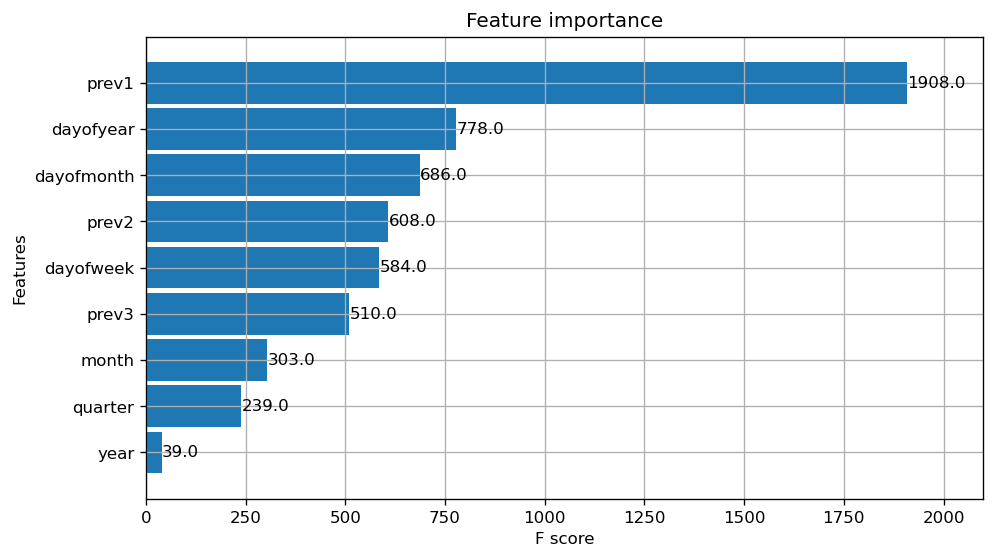

In [59]:
# visualizacion las variables de mas importancia en el modelo
__ = plot_importance(reg,height=0.9)

el primer rezago, dias del año y dias del mes las mas importantes

In [60]:
# realizamos las predicciones para train y test
train_ml['Predictions'] = reg.predict(X_train)
test_ml['Predictions'] = reg.predict(X_test)

In [ ]:
# df con pred y real
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(train_ml['Predictions']),list(train_ml['win_22'])]))